In [5]:
import json
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm, trange


import numpy as np
import torch.optim as optim

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 400

trainset = torchvision.datasets.CIFAR10(root='../../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, drop_last=True,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

print(len(testset))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
10000


batch shape: torch.Size([400, 3, 32, 32])


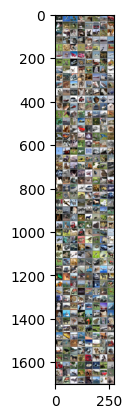

deer  plane bird  bird  dog   dog   plane car   dog   frog  deer  ship  ship  truck horse horse truck dog   dog   bird  dog   horse frog  dog   frog  deer  cat   truck horse ship  ship  ship  deer  frog  frog  bird  truck truck bird  horse car   dog   plane car   frog  plane frog  plane horse deer  car   frog  plane truck frog  truck ship  bird  cat   horse deer  dog   bird  plane truck horse truck bird  dog   ship  ship  plane ship  frog  plane dog   deer  horse ship  frog  bird  deer  ship  cat   truck truck cat   car   cat   ship  car   car   ship  bird  plane plane frog  frog  ship  frog  frog  car   ship  dog   frog  horse cat   deer  horse plane ship  frog  frog  ship  dog   ship  bird  bird  horse ship  truck cat   truck car   bird  truck dog   cat   plane car   deer  truck cat   bird  plane deer  deer  horse dog   deer  bird  horse dog   plane plane ship  deer  plane plane car   ship  horse cat   car   car   bird  truck frog  frog  deer  frog  cat   ship  horse truck horse deer

In [7]:



# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f"batch shape: {images.shape}")

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [11]:
def train(net, trainloader, testloader, criterion, optimizer):
    for epoch in (pbar := trange(1)):  # loop over the dataset multiple times
        running_train_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            inputs = inputs.cuda()
            labels = labels.cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        running_train_loss = running_train_loss / (i + 1)
        test_loss = np.mean([
            criterion(net(inputs.cuda()), labels.cuda())
            for inputs, labels 
            in testloader
        ])
        pbar.set_description(f'train_loss: {running_train_loss:.5f}, test_loss: {test_loss:.5f}')
    return running_train_loss

In [12]:
configs = [
    {'model': ResNet, 'model_config': {'depth': 16, 'kernel_size': 5, 'residual': False}},
    {'model': ResNet, 'model_config': {'depth': 16, 'kernel_size': 5, 'residual': True}},
    {'model': GenResNet, 'model_config': {'depth': 16, 'kernel_size': 5}},
]

In [ ]:
for config in configs:
    net = torch.compile(config['model'](**config['model_config']).cuda())
    print(f'Model parameter count: {count_params(net)}')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)
    final_loss = train(net, trainloader, testloader, criterion, optimizer)
    log_line = {'loss': final_loss, 'model_params': count_params(net), **config}
    print(log_line)
    # log to file
    with open('results3.txt', 'a') as f:
        f.write(str(log_line) + "\n")

Model parameter count: 40160


loss: 2.30287: 100%|██████████| 1/1 [00:25<00:00, 25.56s/it]


{'loss': 2.3028732891082764, 'model_params': 40160, 'model': <class '__main__.ResNet'>, 'model_config': {'depth': 16, 'kernel_size': 5, 'residual': False}}
Model parameter count: 40160


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
for r in net.layer_cons:
    for c in r:
        print(f"{c.item():1.2f} ", end='')
    print("")